In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import PredefinedSplit, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import BaggingClassifier

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from lightgbm import LGBMClassifier

### Load data

In [2]:
data = pickle.load(open('X2008_y2008_Xpre2008_ypre2008_Xall_yall_Xval_yval_cv.pkl', 'rb'))

X_2008, y_2008, X_pre2008, y_pre2008, X_all, y_all, X_val, y_val, cv = data

X_test = pickle.load(open('Xtest.pkl', 'rb'))
X_test.shape

for d in data[:-1]:
    print(d.shape)

### Quadratic Discriminant Analysis

In [6]:
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis(reg_param=1))

scores = cross_val_score(qda, X_all, y_all, cv=cv, scoring='roc_auc')

In [7]:
scores.mean(), scores.std()

(0.83863290079617436, 0.011042972738620316)

In [8]:
qda_grid = GridSearchCV(qda, {'quadraticdiscriminantanalysis__reg_param':np.linspace(0,1,11)}, 
                        cv=cv, scoring='roc_auc')

In [9]:
qda_grid.fit(X_all, y_all)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('quadraticdiscriminantanalysis', QuadraticDiscriminantAnalysis(priors=None, reg_param=1,
               store_covariance=False, store_covariances=None, tol=0.0001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'quadraticdiscriminantanalysis__reg_param': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [10]:
qda_grid.best_score_, qda_grid.best_params_

(0.83863999326421468, {'quadraticdiscriminantanalysis__reg_param': 1.0})

In [11]:
roc_auc_score(y_val, qda_grid.predict_proba(X_val)[:,1])

0.85108044780005199

### Neural Networks

In [12]:
nn = make_pipeline(StandardScaler(), 
                   MLPClassifier(early_stopping=True, batch_size=8, learning_rate_init=.02, 
                                 solver='sgd', hidden_layer_sizes=24,
                                 learning_rate='adaptive', max_iter=1000, random_state=123))

params = {
    #'mlpclassifier__batch_size': [4, 8, 12], 
    #'mlpclassifier__hidden_layer_sizes': [20, 24, 32, 40],
    'mlpclassifier__alpha': [.025, .05, .1],
    #'mlpclassifier__learning_rate_init': [.02, .01, .04],
          }

In [13]:
nn_grid = GridSearchCV(nn, params, cv=cv, scoring='roc_auc', verbose=1)
nn_grid.fit(X_all, y_all)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlpclassifier', MLPClassifier(activation='relu', alpha=0.0001, batch_size=8, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=24, learning_rate='adaptive',
       lear...e=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'mlpclassifier__alpha': [0.025, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [14]:
nn_grid.best_score_, nn_grid.best_params_

(0.91943999883401029, {'mlpclassifier__alpha': 0.05})

In [15]:
roc_auc_score(y_val, nn_grid.predict_proba(X_val)[:, 1])

0.92334353033064298

### LightGBM

In [17]:
lgb = LGBMClassifier(n_estimators=100, max_depth=8, learning_rate=.1)

In [18]:
lgb_grid = GridSearchCV(lgb, {'max_depth': [8, 9, 11]}, cv=cv, scoring='roc_auc', verbose=1)
lgb_grid.fit(X_all, y_all)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.9s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_bin=255, max_depth=8, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8, 9, 11]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=1)

In [19]:
lgb_grid.best_score_, lgb_grid.best_params_

(0.95788115217631442, {'max_depth': 8})

In [20]:
roc_auc_score(y_val, lgb_grid.predict_proba(X_val)[:, 1])

0.96106157250715951

Text(0.5,1,'Feature Importance')

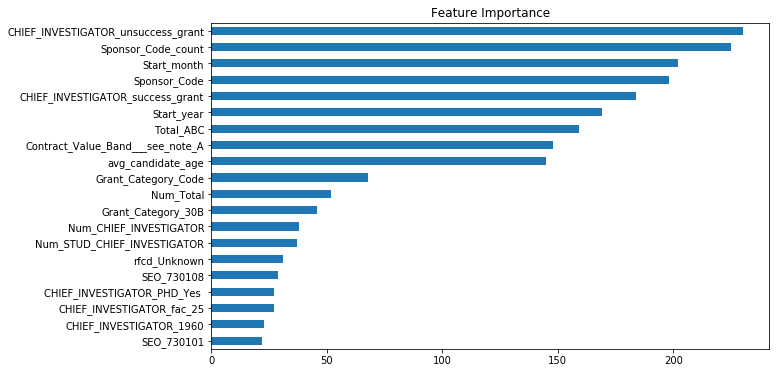

In [21]:
pd.Series(lgb_grid.best_estimator_.feature_importances_, 
          index=X_all.columns).sort_values()[-20:].plot.barh(figsize=(10, 6))
plt.title('Feature Importance')

### Support Vector Machines

In [44]:
params = {'linearsvc__C': [.0001, .0005, .001]}
lin_svc_grid = GridSearchCV(make_pipeline(StandardScaler(), LinearSVC(random_state=123)), 
                            params, cv=cv, scoring='roc_auc', verbose=1)

In [45]:
lin_svc_grid.fit(X_all, y_all)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.3s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'linearsvc__C': [0.0001, 0.0005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [46]:
lin_svc_grid.best_score_, lin_svc_grid.best_params_

(0.88794501110076252, {'linearsvc__C': 0.0005})

In [27]:
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
params = {
    'svc__C': [.0001, .001, .01, .1, 1], 
    'svc__kernel': ['rbf', 'poly'],
}

svc_grid = GridSearchCV(make_pipeline(StandardScaler(), 
                                      SVC(probability=True, random_state=123)), 
                        params, cv=cv, scoring='roc_auc', verbose=1)

In [56]:
svc_grid.fit(X_all, y_all)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 70.9min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=123, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svc__C': [0.0001, 0.001, 0.01, 0.1, 1], 'svc__kernel': ['rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [57]:
# (0.89304943609128995, {'svc__C': 1, 'svc__kernel': 'rbf'})
svc_grid.best_score_, svc_grid.best_params_

(0.89304943609128995, {'svc__C': 1, 'svc__kernel': 'rbf'})

In [6]:
# svm bagging
svm_bagging = BaggingClassifier(SVC(C=1, kernel='rbf'), n_estimators=10, 
                                max_samples=len(X_all)//10, bootstrap=False, random_state=123)

In [8]:
cross_val_score(svm_bagging, X_all, y_all, cv=cv, scoring='roc_auc')

array([ 0.88991367,  0.91130181])

In [9]:
svm_bagging.fit(X_all, y_all)

BaggingClassifier(base_estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=819, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=123, verbose=0, warm_start=False)

In [10]:
roc_auc_score(y_val, svm_bagging.predict_proba(X_val)[:, 1])

0.85884209841187187

## K-Nearest Neighbors

### ROC-AUC Curve

In [58]:

fpr, tpr, _ = roc_curve(y_val, nn_grid.predict_proba(X_val)[:, 1])
fpr_qda, tpr_qda, _ = roc_curve(y_val, qda_grid.predict_proba(X_val)[:, 1])
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, lgb_grid.predict_proba(X_val)[:, 1])
fpr_lsvc, tpr_lsvc, _ = roc_curve(y_val, lin_svc_grid.decision_function(X_val))
fpr_svc, tpr_svc, _ = roc_curve(y_val, svc_grid.predict_proba(X_val)[:, 1])

[0, 1, 0, 1]

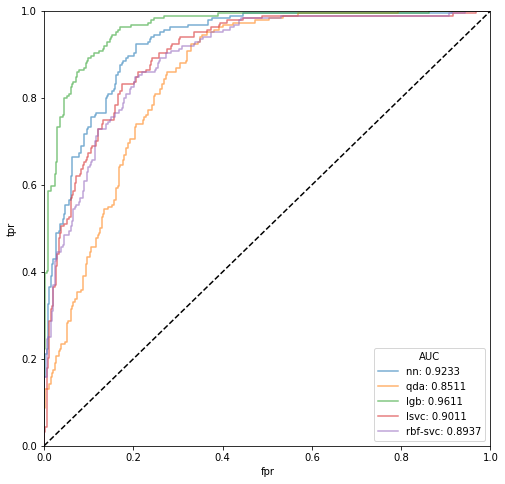

In [60]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, alpha=.6,
         label='nn: {:.4f}'.format(roc_auc_score(y_val, nn_grid.predict_proba(X_val)[:, 1])))
plt.plot(fpr_qda, tpr_qda, alpha=.6,
         label="qda: {:.4f}".format(roc_auc_score(y_val, qda_grid.predict_proba(X_val)[:, 1])))
plt.plot(fpr_lgb, tpr_lgb, alpha=.6,
        label="lgb: {:.4f}".format(roc_auc_score(y_val, lgb_grid.predict_proba(X_val)[:, 1])))
plt.plot(fpr_lsvc, tpr_lsvc, alpha=.6,
        label="lsvc: {:.4f}".format(roc_auc_score(y_val, lin_svc_grid.decision_function(X_val))))
plt.plot(fpr_svc, tpr_svc, alpha=.6,
        label="rbf-svc: {:.4f}".format(roc_auc_score(y_val, svc_grid.predict_proba(X_val)[:, 1])))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(title='AUC')
plt.axis([0,1,0,1])

In [94]:
y_test_pred = nn_grid.predict_proba(X_test)[:, 1]

In [95]:
y_test_pred.shape

(2176,)

In [96]:
test = pd.read_csv('data/GrantApplication/unimelb_test.csv', low_memory=False)

In [99]:
test['Grant.Status'] = y_test_pred

In [ ]:
test['Grant.Application.ID']

In [103]:
test[['Grant.Application.ID','Grant.Status']].to_csv('grant_submit.csv', index=False)

In [ ]:
test.to_csv(in)